In [1]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import Embedding, MaxPooling1D,MaxPooling2D, GlobalAveragePooling1D
from tensorflow.keras.layers import Bidirectional, TimeDistributed, BatchNormalization
from tensorflow.keras.layers import LSTM, CuDNNLSTM, Conv1D, Conv2D, Flatten, CuDNNGRU, GRU, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, Nadam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, LearningRateScheduler
#!pip install livelossplot
import livelossplot
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

import pickle
from numpy import dstack
from sklearn.metrics import accuracy_score

import braindecode
import mne

Using TensorFlow backend.
C:\Users\opeth\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\opeth\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\opeth\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\opeth\Anaconda3\envs\tf_gpu\lib\sit

In [8]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Utilities for exporting TensorFlow symbols to the API.
Exporting a function or a class:
To export a function or a class use tf_export decorator. For e.g.:
```python
@tf_export('foo', 'bar.foo')
def foo(...):
  ...
```
If a function is assigned to a variable, you can export it by calling
tf_export explicitly. For e.g.:
```python
foo = get_foo(...)
tf_export('foo', 'bar.foo')(foo)
```
Exporting a constant
```python
foo = 1
tf_export('consts.foo').export_constant(__name__, 'foo')
```
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import functools
import sys

from tensorflow.python.util import tf_decorator
from tensorflow.python.util import tf_inspect

ESTIMATOR_API_NAME = 'estimator'
KERAS_API_NAME = 'keras'
TENSORFLOW_API_NAME = 'tensorflow'

# List of subpackage names used by TensorFlow components. Have to check that
# TensorFlow core repo does not export any symbols under these names.
SUBPACKAGE_NAMESPACES = [ESTIMATOR_API_NAME]

_Attributes = collections.namedtuple(
    'ExportedApiAttributes', ['names', 'constants'])

# Attribute values must be unique to each API.
API_ATTRS = {
    TENSORFLOW_API_NAME: _Attributes(
        '_tf_api_names',
        '_tf_api_constants'),
    ESTIMATOR_API_NAME: _Attributes(
        '_estimator_api_names',
        '_estimator_api_constants'),
    KERAS_API_NAME: _Attributes(
        '_keras_api_names',
        '_keras_api_constants')
}

API_ATTRS_V1 = {
    TENSORFLOW_API_NAME: _Attributes(
        '_tf_api_names_v1',
        '_tf_api_constants_v1'),
    ESTIMATOR_API_NAME: _Attributes(
        '_estimator_api_names_v1',
        '_estimator_api_constants_v1'),
    KERAS_API_NAME: _Attributes(
        '_keras_api_names_v1',
        '_keras_api_constants_v1')
}


class SymbolAlreadyExposedError(Exception):
  """Raised when adding API names to symbol that already has API names."""
  pass


class InvalidSymbolNameError(Exception):
  """Raised when trying to export symbol as an invalid or unallowed name."""
  pass


def get_canonical_name_for_symbol(
    symbol, api_name=TENSORFLOW_API_NAME,
    add_prefix_to_v1_names=False):
  """Get canonical name for the API symbol.
  Args:
    symbol: API function or class.
    api_name: API name (tensorflow or estimator).
    add_prefix_to_v1_names: Specifies whether a name available only in V1
      should be prefixed with compat.v1.
  Returns:
    Canonical name for the API symbol (for e.g. initializers.zeros) if
    canonical name could be determined. Otherwise, returns None.
  """
  if not hasattr(symbol, '__dict__'):
    return None
  api_names_attr = API_ATTRS[api_name].names
  _, undecorated_symbol = tf_decorator.unwrap(symbol)
  if api_names_attr not in undecorated_symbol.__dict__:
    return None
  api_names = getattr(undecorated_symbol, api_names_attr)
  deprecated_api_names = undecorated_symbol.__dict__.get(
      '_tf_deprecated_api_names', [])

  canonical_name = get_canonical_name(api_names, deprecated_api_names)
  if canonical_name:
    return canonical_name

  # If there is no V2 canonical name, get V1 canonical name.
  api_names_attr = API_ATTRS_V1[api_name].names
  api_names = getattr(undecorated_symbol, api_names_attr)
  v1_canonical_name = get_canonical_name(api_names, deprecated_api_names)
  if add_prefix_to_v1_names:
    return 'compat.v1.%s' % v1_canonical_name
  return v1_canonical_name


def get_canonical_name(api_names, deprecated_api_names):
  """Get preferred endpoint name.
  Args:
    api_names: API names iterable.
    deprecated_api_names: Deprecated API names iterable.
  Returns:
    Returns one of the following in decreasing preference:
    - first non-deprecated endpoint
    - first endpoint
    - None
  """
  non_deprecated_name = next(
      (name for name in api_names if name not in deprecated_api_names),
      None)
  if non_deprecated_name:
    return non_deprecated_name
  if api_names:
    return api_names[0]
  return None


def get_v1_names(symbol):
  """Get a list of TF 1.* names for this symbol.
  Args:
    symbol: symbol to get API names for.
  Returns:
    List of all API names for this symbol including TensorFlow and
    Estimator names.
  """
  names_v1 = []
  tensorflow_api_attr_v1 = API_ATTRS_V1[TENSORFLOW_API_NAME].names
  estimator_api_attr_v1 = API_ATTRS_V1[ESTIMATOR_API_NAME].names
  keras_api_attr_v1 = API_ATTRS_V1[KERAS_API_NAME].names

  if not hasattr(symbol, '__dict__'):
    return names_v1
  if tensorflow_api_attr_v1 in symbol.__dict__:
    names_v1.extend(getattr(symbol, tensorflow_api_attr_v1))
  if estimator_api_attr_v1 in symbol.__dict__:
    names_v1.extend(getattr(symbol, estimator_api_attr_v1))
  if keras_api_attr_v1 in symbol.__dict__:
    names_v1.extend(getattr(symbol, keras_api_attr_v1))
  return names_v1


def get_v2_names(symbol):
  """Get a list of TF 2.0 names for this symbol.
  Args:
    symbol: symbol to get API names for.
  Returns:
    List of all API names for this symbol including TensorFlow and
    Estimator names.
  """
  names_v2 = []
  tensorflow_api_attr = API_ATTRS[TENSORFLOW_API_NAME].names
  estimator_api_attr = API_ATTRS[ESTIMATOR_API_NAME].names
  keras_api_attr = API_ATTRS[KERAS_API_NAME].names

  if not hasattr(symbol, '__dict__'):
    return names_v2
  if tensorflow_api_attr in symbol.__dict__:
    names_v2.extend(getattr(symbol, tensorflow_api_attr))
  if estimator_api_attr in symbol.__dict__:
    names_v2.extend(getattr(symbol, estimator_api_attr))
  if keras_api_attr in symbol.__dict__:
    names_v2.extend(getattr(symbol, keras_api_attr))
  return names_v2


def get_v1_constants(module):
  """Get a list of TF 1.* constants in this module.
  Args:
    module: TensorFlow module.
  Returns:
    List of all API constants under the given module including TensorFlow and
    Estimator constants.
  """
  constants_v1 = []
  tensorflow_constants_attr_v1 = API_ATTRS_V1[TENSORFLOW_API_NAME].constants
  estimator_constants_attr_v1 = API_ATTRS_V1[ESTIMATOR_API_NAME].constants

  if hasattr(module, tensorflow_constants_attr_v1):
    constants_v1.extend(getattr(module, tensorflow_constants_attr_v1))
  if hasattr(module, estimator_constants_attr_v1):
    constants_v1.extend(getattr(module, estimator_constants_attr_v1))
  return constants_v1


def get_v2_constants(module):
  """Get a list of TF 2.0 constants in this module.
  Args:
    module: TensorFlow module.
  Returns:
    List of all API constants under the given module including TensorFlow and
    Estimator constants.
  """
  constants_v2 = []
  tensorflow_constants_attr = API_ATTRS[TENSORFLOW_API_NAME].constants
  estimator_constants_attr = API_ATTRS[ESTIMATOR_API_NAME].constants

  if hasattr(module, tensorflow_constants_attr):
    constants_v2.extend(getattr(module, tensorflow_constants_attr))
  if hasattr(module, estimator_constants_attr):
    constants_v2.extend(getattr(module, estimator_constants_attr))
  return constants_v2


class api_export(object):  # pylint: disable=invalid-name
  """Provides ways to export symbols to the TensorFlow API."""

  def __init__(self, *args, **kwargs):  # pylint: disable=g-doc-args
    """Export under the names *args (first one is considered canonical).
    Args:
      *args: API names in dot delimited format.
      **kwargs: Optional keyed arguments.
        v1: Names for the TensorFlow V1 API. If not set, we will use V2 API
          names both for TensorFlow V1 and V2 APIs.
        overrides: List of symbols that this is overriding
          (those overrided api exports will be removed). Note: passing overrides
          has no effect on exporting a constant.
        api_name: Name of the API you want to generate (e.g. `tensorflow` or
          `estimator`). Default is `tensorflow`.
        allow_multiple_exports: Allow symbol to be exported multiple time under
          different names.
    """
    self._names = args
    self._names_v1 = kwargs.get('v1', args)
    if 'v2' in kwargs:
      raise ValueError('You passed a "v2" argument to tf_export. This is not '
                       'what you want. Pass v2 names directly as positional '
                       'arguments instead.')
    self._api_name = kwargs.get('api_name', TENSORFLOW_API_NAME)
    self._overrides = kwargs.get('overrides', [])
    self._allow_multiple_exports = kwargs.get('allow_multiple_exports', False)

    self._validate_symbol_names()

  def _validate_symbol_names(self):
    """Validate you are exporting symbols under an allowed package.
    We need to ensure things exported by tf_export, estimator_export, etc.
    export symbols under disjoint top-level package names.
    For TensorFlow, we check that it does not export anything under subpackage
    names used by components (estimator, keras, etc.).
    For each component, we check that it exports everything under its own
    subpackage.
    Raises:
      InvalidSymbolNameError: If you try to export symbol under disallowed name.
    """
    all_symbol_names = set(self._names) | set(self._names_v1)
    if self._api_name == TENSORFLOW_API_NAME:
      for subpackage in SUBPACKAGE_NAMESPACES:
        if any(n.startswith(subpackage) for n in all_symbol_names):
          raise InvalidSymbolNameError(
              '@tf_export is not allowed to export symbols under %s.*' % (
                  subpackage))
    else:
      if not all(n.startswith(self._api_name) for n in all_symbol_names):
        raise InvalidSymbolNameError(
            'Can only export symbols under package name of component. '
            'e.g. tensorflow_estimator must export all symbols under '
            'tf.estimator')

  def __call__(self, func):
    """Calls this decorator.
    Args:
      func: decorated symbol (function or class).
    Returns:
      The input function with _tf_api_names attribute set.
    Raises:
      SymbolAlreadyExposedError: Raised when a symbol already has API names
        and kwarg `allow_multiple_exports` not set.
    """
    api_names_attr = API_ATTRS[self._api_name].names
    api_names_attr_v1 = API_ATTRS_V1[self._api_name].names
    # Undecorate overridden names
    for f in self._overrides:
      _, undecorated_f = tf_decorator.unwrap(f)
      delattr(undecorated_f, api_names_attr)
      delattr(undecorated_f, api_names_attr_v1)

    _, undecorated_func = tf_decorator.unwrap(func)
    self.set_attr(undecorated_func, api_names_attr, self._names)
    self.set_attr(undecorated_func, api_names_attr_v1, self._names_v1)
    return func

  def set_attr(self, func, api_names_attr, names):
    # Check for an existing api. We check if attribute name is in
    # __dict__ instead of using hasattr to verify that subclasses have
    # their own _tf_api_names as opposed to just inheriting it.
    if api_names_attr in func.__dict__:
      if not self._allow_multiple_exports:
        raise SymbolAlreadyExposedError(
            'Symbol %s is already exposed as %s.' %
            (func.__name__, getattr(func, api_names_attr)))  # pylint: disable=protected-access
    setattr(func, api_names_attr, names)

  def export_constant(self, module_name, name):
    """Store export information for constants/string literals.
    Export information is stored in the module where constants/string literals
    are defined.
    e.g.
    ```python
    foo = 1
    bar = 2
    tf_export("consts.foo").export_constant(__name__, 'foo')
    tf_export("consts.bar").export_constant(__name__, 'bar')
    ```
    Args:
      module_name: (string) Name of the module to store constant at.
      name: (string) Current constant name.
    """
    module = sys.modules[module_name]
    api_constants_attr = API_ATTRS[self._api_name].constants
    api_constants_attr_v1 = API_ATTRS_V1[self._api_name].constants

    if not hasattr(module, api_constants_attr):
      setattr(module, api_constants_attr, [])
    # pylint: disable=protected-access
    getattr(module, api_constants_attr).append(
        (self._names, name))

    if not hasattr(module, api_constants_attr_v1):
      setattr(module, api_constants_attr_v1, [])
    getattr(module, api_constants_attr_v1).append(
        (self._names_v1, name))


def kwarg_only(f):
  """A wrapper that throws away all non-kwarg arguments."""
  f_argspec = tf_inspect.getargspec(f)

  def wrapper(*args, **kwargs):
    if args:
      raise TypeError(
          '{f} only takes keyword args (possible keys: {kwargs}). '
          'Please pass these args as kwargs instead.'
          .format(f=f.__name__, kwargs=f_argspec.args))
    return f(**kwargs)

  return tf_decorator.make_decorator(f, wrapper, decorator_argspec=f_argspec)


tf_export = functools.partial(api_export, api_name=TENSORFLOW_API_NAME)
estimator_export = functools.partial(api_export, api_name=ESTIMATOR_API_NAME)
keras_export = functools.partial(api_export, api_name=KERAS_API_NAME)

In [9]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Attention layers that can be used in sequence DNN/CNN models.
This file follows the terminology of https://arxiv.org/abs/1706.03762 Figure 2.
Attention is formed by three tensors: Query, Key and Value.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
#from tensorflow.python.util.tf_export import keras_export


class BaseDenseAttention(Layer):
  """Base Attention class for Dense networks.
  This class is suitable for Dense or CNN networks, and not for RNN networks.
  Implementations of attention mechanisms should inherit from this class, and
  reuse the `apply_attention_scores()` method.
  Args:
    causal: Boolean. Set to `True` for decoder self-attention. Adds a mask such
      that position `i` cannot attend to positions `j > i`. This prevents the
      flow of information from the future towards the past.
  Call Arguments:
    inputs: List of the following tensors:
      * query: Query `Tensor` of shape `[batch_size, Tq, dim]`.
      * value: Value `Tensor` of shape `[batch_size, Tv, dim]`.
      * key: Optional key `Tensor` of shape `[batch_size, Tv, dim]`. If not
        given, will use `value` for both `key` and `value`, which is the
        most common case.
    mask: List of the following tensors:
      * query_mask: A boolean mask `Tensor` of shape `[batch_size, Tq]`.
        If given, the output will be zero at the positions where
        `mask==False`.
      * value_mask: A boolean mask `Tensor` of shape `[batch_size, Tv]`.
        If given, will apply the mask such that values at positions where
        `mask==False` do not contribute to the result.
  Output shape:
    Attention outputs of shape `[batch_size, Tq, dim]`.
  """

  def __init__(self, causal=False, **kwargs):
    super(BaseDenseAttention, self).__init__(**kwargs)
    self.causal = causal
    self.supports_masking = True

  def _calculate_scores(self, query, key):
    """Calculates attention scores.
    Args:
      query: Query tensor of shape `[batch_size, Tq, dim]`.
      key: Key tensor of shape `[batch_size, Tv, dim]`.
    Returns:
      Tensor of shape `[batch_size, Tq, Tv]`.
    """
    return NotImplementedError

  def _apply_scores(self, scores, value, scores_mask=None):
    """Applies attention scores to the given value tensor.
    To use this method in your attention layer, follow the steps:
    * Use `query` tensor of shape `[batch_size, Tq]` and `key` tensor of shape
      `[batch_size, Tv]` to calculate the attention `scores`.
    * Pass `scores` and `value` tensors to this method. The method applies
      `scores_mask`, calculates `attention_distribution = softmax(scores)`, then
      returns `matmul(attention_distribution, value).
    * Apply `query_mask` and return the result.
    Args:
      scores: Scores float tensor of shape `[batch_size, Tq, Tv]`.
      value: Value tensor of shape `[batch_size, Tv, dim]`.
      scores_mask: A boolean mask `Tensor` of shape `[batch_size, 1, Tv]` or
        `[batch_size, Tq, Tv]`. If given, scores at positions where
        `scores_mask==False` do not contribute to the result. It must contain
        at least one `True` value in each line along the last dimension.
    Returns:
      Tensor of shape `[batch_size, Tq, dim]`.
    """
    if scores_mask is not None:
      padding_mask = math_ops.logical_not(scores_mask)
      # Bias so padding positions do not contribute to attention distribution.
      scores -= 1.e9 * math_ops.cast(padding_mask, dtype=K.floatx())
    attention_distribution = nn.softmax(scores)
    return math_ops.matmul(attention_distribution, value)

  # TODO(b/125916026): Consider exposing a __call__ method with named args.
  def call(self, inputs, mask=None):
    self._validate_call_args(inputs=inputs, mask=mask)
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v
    q_mask = mask[0] if mask else None
    v_mask = mask[1] if mask else None
    scores = self._calculate_scores(query=q, key=k)
    if v_mask is not None:
      # Mask of shape [batch_size, 1, Tv].
      v_mask = array_ops.expand_dims(v_mask, axis=-2)
    if self.causal:
      # Creates a lower triangular mask, so position i cannot attend to
      # positions j>i. This prevents the flow of information from the future
      # into the past.
      scores_shape = array_ops.shape(scores)
      # causal_mask_shape = [1, Tq, Tv].
      causal_mask_shape = array_ops.concat(
          [array_ops.ones_like(scores_shape[:-2]), scores_shape[-2:]],
          axis=0)
      causal_mask = _lower_triangular_mask(causal_mask_shape)
    else:
      causal_mask = None
    scores_mask = _merge_masks(v_mask, causal_mask)
    result = self._apply_scores(scores=scores, value=v, scores_mask=scores_mask)
    if q_mask is not None:
      # Mask of shape [batch_size, Tq, 1].
      q_mask = array_ops.expand_dims(q_mask, axis=-1)
      result *= math_ops.cast(q_mask, dtype=result.dtype)
    return result

  def compute_mask(self, inputs, mask=None):
    self._validate_call_args(inputs=inputs, mask=mask)
    if mask:
      q_mask = mask[0]
      if q_mask is None:
        return None
      return ops.convert_to_tensor(q_mask)
    return None

  def _validate_call_args(self, inputs, mask):
    """Validates arguments of the call method."""
    class_name = self.__class__.__name__
    if not isinstance(inputs, list):
      raise ValueError(
          '{} layer must be called on a list of inputs, namely [query, value] '
          'or [query, value, key].'.format(class_name))
    if len(inputs) < 2 or len(inputs) > 3:
      raise ValueError(
          '{} layer accepts inputs list of length 2 or 3, '
          'namely [query, value] or [query, value, key]. '
          'Given length: {}'.format(class_name, len(inputs)))
    if mask:
      if not isinstance(mask, list):
        raise ValueError(
            '{} layer mask must be a list, '
            'namely [query_mask, value_mask].'.format(class_name))
      if len(mask) != 2:
        raise ValueError(
            '{} layer mask must be a list of length 2, namely [query_mask, '
            'value_mask]. Given length: {}'.format(class_name, len(mask)))


@keras_export('keras.layers.Attention')
class Attention(BaseDenseAttention):
  """Dot-product attention layer, a.k.a. Luong-style attention.
  Inputs are `query` tensor of shape `[batch_size, Tq, dim]`, `value` tensor of
  shape `[batch_size, Tv, dim]` and `key` tensor of shape
  `[batch_size, Tv, dim]`. The calculation follows the steps:
  1. Calculate scores with shape `[batch_size, Tq, Tv]` as a `query`-`key` dot
     product: `scores = tf.matmul(query, key, transpose_b=True)`.
  2. Use scores to calculate a distribution with shape
     `[batch_size, Tq, Tv]`: `distribution = tf.nn.softmax(scores)`.
  3. Use `distribution` to create a linear combination of `value` with
     shape `batch_size, Tq, dim]`:
     `return tf.matmul(distribution, value)`.
  Args:
    use_scale: If `True`, will create a scalar variable to scale the attention
      scores.
    causal: Boolean. Set to `True` for decoder self-attention. Adds a mask such
      that position `i` cannot attend to positions `j > i`. This prevents the
      flow of information from the future towards the past.
  Call Arguments:
    inputs: List of the following tensors:
      * query: Query `Tensor` of shape `[batch_size, Tq, dim]`.
      * value: Value `Tensor` of shape `[batch_size, Tv, dim]`.
      * key: Optional key `Tensor` of shape `[batch_size, Tv, dim]`. If not
        given, will use `value` for both `key` and `value`, which is the
        most common case.
    mask: List of the following tensors:
      * query_mask: A boolean mask `Tensor` of shape `[batch_size, Tq]`.
        If given, the output will be zero at the positions where
        `mask==False`.
      * value_mask: A boolean mask `Tensor` of shape `[batch_size, Tv]`.
        If given, will apply the mask such that values at positions where
        `mask==False` do not contribute to the result.
  Output shape:
    Attention outputs of shape `[batch_size, Tq, dim]`.
  The meaning of `query`, `value` and `key` depend on the application. In the
  case of text similarity, for example, `query` is the sequence embeddings of
  the first piece of text and `value` is the sequence embeddings of the second
  piece of text. `key` is usually the same tensor as `value`.
  Here is a code example for using `Attention` in a CNN+Attention network:
  ```python
  # Variable-length int sequences.
  query_input = tf.keras.Input(shape=(None,), dtype='int32')
  value_input = tf.keras.Input(shape=(None,), dtype='int32')
  # Embedding lookup.
  token_embedding = tf.keras.layers.Embedding(max_tokens, dimension)
  # Query embeddings of shape [batch_size, Tq, dimension].
  query_embeddings = token_embedding(query_input)
  # Value embeddings of shape [batch_size, Tv, dimension].
  value_embeddings = token_embedding(query_input)
  # CNN layer.
  cnn_layer = tf.keras.layers.Conv1D(
      filters=100,
      kernel_size=4,
      # Use 'same' padding so outputs have the same shape as inputs.
      padding='same')
  # Query encoding of shape [batch_size, Tq, filters].
  query_seq_encoding = cnn_layer(query_embeddings)
  # Value encoding of shape [batch_size, Tv, filters].
  value_seq_encoding = cnn_layer(value_embeddings)
  # Query-value attention of shape [batch_size, Tq, filters].
  query_value_attention_seq = tf.keras.layers.Attention()(
      [query_seq_encoding, value_seq_encoding])
  # Reduce over the sequence axis to produce encodings of shape
  # [batch_size, filters].
  query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
      query_seq_encoding)
  query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
      query_value_attention_seq)
  # Concatenate query and document encodings to produce a DNN input layer.
  input_layer = tf.keras.layers.Concatenate()(
      [query_encoding, query_value_attention])
  # Add DNN layers, and create Model.
  # ...
  ```
  """

  def __init__(self, use_scale=False, **kwargs):
    super(Attention, self).__init__(**kwargs)
    self.use_scale = use_scale

  def build(self, input_shape):
    """Creates scale variable if use_scale==True."""
    if self.use_scale:
      self.scale = self.add_weight(
          name='scale',
          shape=(),
          initializer=init_ops.ones_initializer(),
          dtype=self.dtype,
          trainable=True)
    else:
      self.scale = None
    super(Attention, self).build(input_shape)

  def _calculate_scores(self, query, key):
    """Calculates attention scores as a query-key dot product.
    Args:
      query: Query tensor of shape `[batch_size, Tq, dim]`.
      key: Key tensor of shape `[batch_size, Tv, dim]`.
    Returns:
      Tensor of shape `[batch_size, Tq, Tv]`.
    """
    scores = math_ops.matmul(query, key, transpose_b=True)
    if self.scale is not None:
      scores *= self.scale
    return scores


@keras_export('keras.layers.AdditiveAttention')
class AdditiveAttention(BaseDenseAttention):
  """Additive attention layer, a.k.a. Bahdanau-style attention.
  Inputs are `query` tensor of shape `[batch_size, Tq, dim]`, `value` tensor of
  shape `[batch_size, Tv, dim]` and `key` tensor of shape
  `[batch_size, Tv, dim]`. The calculation follows the steps:
  1. Reshape `query` and `value` into shapes `[batch_size, Tq, 1, dim]`
     and `[batch_size, 1, Tv, dim]` respectively.
  2. Calculate scores with shape `[batch_size, Tq, Tv]` as a non-linear
     sum: `scores = tf.reduce_sum(tf.tanh(query + value), axis=-1)`
  3. Use scores to calculate a distribution with shape
     `[batch_size, Tq, Tv]`: `distribution = tf.nn.softmax(scores)`.
  4. Use `distribution` to create a linear combination of `value` with
     shape `batch_size, Tq, dim]`:
     `return tf.matmul(distribution, value)`.
  Args:
    use_scale: If `True`, will create a variable to scale the attention scores.
    causal: Boolean. Set to `True` for decoder self-attention. Adds a mask such
      that position `i` cannot attend to positions `j > i`. This prevents the
      flow of information from the future towards the past.
  Call Arguments:
    inputs: List of the following tensors:
      * query: Query `Tensor` of shape `[batch_size, Tq, dim]`.
      * value: Value `Tensor` of shape `[batch_size, Tv, dim]`.
      * key: Optional key `Tensor` of shape `[batch_size, Tv, dim]`. If not
        given, will use `value` for both `key` and `value`, which is the
        most common case.
    mask: List of the following tensors:
      * query_mask: A boolean mask `Tensor` of shape `[batch_size, Tq]`.
        If given, the output will be zero at the positions where
        `mask==False`.
      * value_mask: A boolean mask `Tensor` of shape `[batch_size, Tv]`.
        If given, will apply the mask such that values at positions where
        `mask==False` do not contribute to the result.
  Output shape:
    Attention outputs of shape `[batch_size, Tq, dim]`.
  The meaning of `query`, `value` and `key` depend on the application. In the
  case of text similarity, for example, `query` is the sequence embeddings of
  the first piece of text and `value` is the sequence embeddings of the second
  piece of text. `key` is usually the same tensor as `value`.
  Here is a code example for using `AdditiveAttention` in a CNN+Attention
  network:
  ```python
  # Variable-length int sequences.
  query_input = tf.keras.Input(shape=(None,), dtype='int32')
  value_input = tf.keras.Input(shape=(None,), dtype='int32')
  # Embedding lookup.
  token_embedding = tf.keras.layers.Embedding(max_tokens, dimension)
  # Query embeddings of shape [batch_size, Tq, dimension].
  query_embeddings = token_embedding(query_input)
  # Value embeddings of shape [batch_size, Tv, dimension].
  value_embeddings = token_embedding(query_input)
  # CNN layer.
  cnn_layer = tf.keras.layers.Conv1D(
      filters=100,
      kernel_size=4,
      # Use 'same' padding so outputs have the same shape as inputs.
      padding='same')
  # Query encoding of shape [batch_size, Tq, filters].
  query_seq_encoding = cnn_layer(query_embeddings)
  # Value encoding of shape [batch_size, Tv, filters].
  value_seq_encoding = cnn_layer(value_embeddings)
  # Query-value attention of shape [batch_size, Tq, filters].
  query_value_attention_seq = tf.keras.layers.AdditiveAttention()(
      [query_seq_encoding, value_seq_encoding])
  # Reduce over the sequence axis to produce encodings of shape
  # [batch_size, filters].
  query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
      query_seq_encoding)
  query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
      query_value_attention_seq)
  # Concatenate query and document encodings to produce a DNN input layer.
  input_layer = tf.keras.layers.Concatenate()(
      [query_encoding, query_value_attention])
  # Add DNN layers, and create Model.
  # ...
  ```
  """

  def __init__(self, use_scale=True, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.use_scale = use_scale

  def build(self, input_shape):
    v_shape = tensor_shape.TensorShape(input_shape[1])
    dim = v_shape[-1]
    if isinstance(dim, tensor_shape.Dimension):
      dim = dim.value
    if self.use_scale:
      self.scale = self.add_weight(
          name='scale',
          shape=[dim],
          initializer=init_ops.glorot_uniform_initializer(),
          dtype=self.dtype,
          trainable=True)
    else:
      self.scale = None
    super(AdditiveAttention, self).build(input_shape)

  def _calculate_scores(self, query, key):
    """Calculates attention scores as a nonlinear sum of query and key.
    Args:
      query: Query tensor of shape `[batch_size, Tq, dim]`.
      key: Key tensor of shape `[batch_size, Tv, dim]`.
    Returns:
      Tensor of shape `[batch_size, Tq, Tv]`.
    """
    # Reshape tensors to enable broadcasting.
    # Reshape into [batch_size, Tq, 1, dim].
    q_reshaped = array_ops.expand_dims(query, axis=-2)
    # Reshape into [batch_size, 1, Tv, dim].
    k_reshaped = array_ops.expand_dims(key, axis=-3)
    if self.use_scale:
      scale = self.scale
    else:
      scale = 1.
    return math_ops.reduce_sum(
        scale * math_ops.tanh(q_reshaped + k_reshaped), axis=-1)


def _lower_triangular_mask(shape):
  """Creates a lower-triangular boolean mask over the last 2 dimensions."""
  row_index = math_ops.cumsum(
      array_ops.ones(shape=shape, dtype=dtypes.int32), axis=-2)
  col_index = math_ops.cumsum(
      array_ops.ones(shape=shape, dtype=dtypes.int32), axis=-1)
  return math_ops.greater_equal(row_index, col_index)


def _merge_masks(x, y):
  if x is None:
    return y
  if y is None:
    return x
  return math_ops.logical_and(x, y)

# 1. Run from here to read the raw data

In [2]:
import mne
import numpy as np
from mne.io import concatenate_raws
from braindecode.datautil.signal_target import SignalAndTarget

# First 80 subjects as train
physionet_paths = [ mne.datasets.eegbci.load_data(sub_id,[4,8,12,]) for sub_id in range(1,110) if sub_id not in [88,89,90,91,92,93,94,100,101,102,103,104,105,106,107,108]]
physionet_paths = np.concatenate(physionet_paths)
parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto')
         for path in physionet_paths]

raw = concatenate_raws(parts)

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Find the events in this dataset
events, _ = mne.events_from_annotations(raw)

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epoched = mne.Epochs(raw, events, dict(hands=2, feet=3), tmin=1, tmax=4.1, proj=False, picks=picks,
                baseline=None, preload=True)



train_raw_X = (epoched.get_data() * 1e6).astype(np.float32)
train_raw_y = (epoched.events[:,2] - 2).astype(np.int64) #2,3 -> 0,1
train_set = SignalAndTarget(train_raw_X[:3473], y=train_raw_y[:3473])
valid_set = SignalAndTarget(train_raw_X[3473:3873], y =train_raw_y[3473:3873])
test_set = SignalAndTarget(train_raw_X[3873:], y=train_raw_y[3873:])

# train_raw_X = (epoched.get_data() * 1e6).astype(np.float32)
# train_raw_y = (epoched.events[:,2] - 2).astype(np.int64) #2,3 -> 0,1
# train_set = SignalAndTarget(train_raw_X[:30], y=train_raw_y[:30])
# valid_set = SignalAndTarget(train_raw_X[30:40], y =train_raw_y[30:40])
# test_set = SignalAndTarget(train_raw_X[40:], y=train_raw_y[40:])


del train_raw_X, train_raw_y, epoched, events, picks, raw, parts, physionet_paths

train_set.X = np.transpose(train_set.X,(0,2,1))
valid_set.X = np.transpose(valid_set.X,(0,2,1))
test_set.X = np.transpose(test_set.X,(0,2,1))

Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R04.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R08.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Sett

EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S008\S008R08.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S008\S008R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Use

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S015\S015R08.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S015\S015R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_d

Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S022\S022R08.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S022\S022R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\dat

Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S029\S029R08.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S029\S029R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S030\S030R04.edf

Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S036\S036R08.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S036\S036R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S037\S037R04.edf...
EDF file detected
EDF annotations detected (consider

Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S043\S043R08.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S043\S043R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S044\S044R04.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Sett

EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S050\S050R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S051\S051R04.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Use

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S057\S057R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S058\S058R04.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_d

Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S064\S064R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S065\S065R04.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\dat

Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S071\S071R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S072\S072R04.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S072\S072R08.edf

Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S078\S078R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S079\S079R04.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S079\S079R08.edf...
EDF file detected
EDF annotations detected (consider

Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S085\S085R12.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S086\S086R04.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S086\S086R08.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Sett

EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S109\S109R04.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\opeth\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S109\S109R08.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Use

# Stop


# 2. Run from here to read the sobi data

In [7]:
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import scipy.io
#Human Sorting
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
def read_sobiSignals_labels(path_sobi_signals, path_all_channels_raw, path_labels, all_channels_raw = False, sobi = False, freq=False):
    
    if all_channels_raw == True:
        #Save the labels names in a list and afterwards sort it
        list_signals = []
        onlyfiles = [f for f in listdir(path_sobi_signals) if isfile(join(path_sobi_signals, f))]
        for i in onlyfiles:
            list_signals.append(str(i))
        list_signals.sort(key=natural_keys)

            #Read the files based on the scaled lists
        if freq == False:
            signals = []
            for i in list_signals:
                signals.append(scipy.io.loadmat(path_sobi_signals+i)['record'])
            signals = np.array(signals)
        else:
            signals = []
            for i in list_signals:
                signals.append(scipy.io.loadmat(path_sobi_signals+i)['Filtered_Y'])
            signals = np.array(signals)
    
    if sobi == True:
        list_signals = []
        onlyfiles = [f for f in listdir(path_sobi_signals) if isfile(join(path_sobi_signals, f))]
        for i in onlyfiles:
            list_signals.append(str(i))
        list_signals.sort(key=natural_keys)


        #Read the files based on the scaled lists
        signals = []
        for i in list_signals:
            if i != 'label.mat':
                signals.append(scipy.io.loadmat(path_sobi_signals+i)['Total_filtered'])
        signals = np.array(signals)

      
    
    

    labels = scipy.io.loadmat(path_labels + 'label.mat')['out'] 
#     labels = np.array(labels)
#     labels = np.reshape(labels,(labels.shape[0]*labels.shape[1],labels.shape[2],labels.shape[3]))
    
    return(signals, labels)

In [10]:
# path_sobi_signals = 'E:\\master_thmmy\\outPath_signals\\sobi_signals\\for_thesis\\original_sobi_data\\original_data_sobi_signals\\'
# path_all_channels_raw = 'E:\\master_thmmy\\outPath_signals\\pre_sobi_signals\\seperate_labels\\signals_s\\' 
path_labels = 'E:\\master_thmmy\\outPath_signals\\sobi_signals\\for_thesis\\original_sobi_data\\original_data_labels\\'

path_sobi_signals = 'E:\\master_thmmy\\outPath_signals\\sobi_signals\\for_thesis\\total_filtered\\total_filtered_signals\\'
path_all_channels_raw = 'E:\\master_thmmy\\outPath_signals\\pre_sobi_signals\\seperate_labels\\signals_s\\' 
#path_labels = 'E:\\master_thmmy\\outPath_signals\\sobi_signals\\for_thesis\\total_filtered\\totaled_filtered_labels\\'


signals, labels = read_sobiSignals_labels(path_sobi_signals, path_all_channels_raw, path_labels, all_channels_raw = False, sobi =True)

sobi_signals = signals
sobi_signals = np.transpose(signals,(0,2,1))
X = sobi_signals.astype(np.float32)

sobi_labels = np.transpose(labels,(1,0))
sobi_labels = np.reshape(sobi_labels,(len(sobi_labels),))
y = sobi_labels.astype(np.int64)



from braindecode.datautil.signal_target import SignalAndTarget




 # train_set = SignalAndTarget(train_raw_X[:3177], y=train_raw_y[:3177])
# valid_set = SignalAndTarget(train_raw_X[3177:3577], y =train_raw_y[3177:3577])
# test_set = SignalAndTarget(train_raw_X[3577:], y=train_raw_y[3577:])

train_set = SignalAndTarget(X[:3473], y=y[:3473])
valid_set = SignalAndTarget(X[3473:3873], y=y[3473:3873])
test_set = SignalAndTarget(X[3873:],y=y[3873:])


del y,X,sobi_labels,sobi_signals, signals, labels

train_set.X = np.transpose(train_set.X,(0,2,1))
valid_set.X = np.transpose(valid_set.X,(0,2,1))
test_set.X = np.transpose(test_set.X,(0,2,1))

### 2.1 Standardize the data (If you train the models on raw data don t scale them)

In [15]:

import numpy as np
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler


class NDStandardScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

scaler = NDStandardScaler()
scaler.fit(train_set.X)


train_set.X =scaler.transform(train_set.X)
test_set.X =scaler.transform(test_set.X)

### 2.2 Or normalize them

In [7]:

import numpy as np
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler

class NDMinMaxScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = MinMaxScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

scaler = NDMinMaxScaler()
scaler.fit(train_set.X)

train_set.X =scaler.transform(train_set.X)
test_set.X =scaler.transform(test_set.X)



# 3. Training

### 3.1 Define the models

In [228]:
# With REGULARIZERS
from keras.regularizers import l2, l1
def fit_model(trainX, trainy, input_shape, activation, dropout, model_name, dir_weights, reg = 0.01, validation_data = None):

    sd = []
    class LossHistory(Callback):
        def on_train_begin(self, logs={}):
            self.losses = [1e15,1e15]

        def on_epoch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            sd.append(step_decay(len(self.losses)))
            print('Learning Rate:', step_decay(len(self.losses)))

    def step_decay(losses):
        minumum = float(min(np.array(history.losses)))
        diff = float(np.array(history.losses[-1])) - minumum
        if len(history.losses) > 3:
            if abs(diff) < 1e8 and sd[-1] > 0.0001:
                lrate = sd[-1] * 0.90
            else:
                lrate = 0.001
        else:
            lrate = 0.001
        return lrate  

    if model_name=='LSTM_CNN':   
        hidden_layers = 64
        #define model 
        kernel_init = 'glorot_uniform'
        model = Sequential()

        model.add(CuDNNLSTM(int(hidden_layers), kernel_initializer = kernel_init, input_shape = input_shape,  
                            return_sequences=True, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Conv1D(int(hidden_layers), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers), kernel_size=(3), activation='relu', padding = 'same', 
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(MaxPooling1D(pool_size=(4), strides = (2)))


        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='relu', padding = 'same', 
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(MaxPooling1D(pool_size=(4), strides = (2)))
    
        model.add(Conv1D(int(hidden_layers*3), kernel_size=(3), activation='relu', padding = 'same', 
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*3), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(MaxPooling1D(pool_size=(4), strides = (2)))
        
        model.add(Flatten())
       
        model.add(Dense(1, activation='sigmoid'))    
        model.compile(loss='binary_crossentropy',  optimizer = Adam(lr=0.001), metrics=['accuracy','mse','mae'])
        

    if model_name=='ConvPoolCnn':   
        hidden_layers = 64
        #define model 
        model = Sequential()

        model.add(Conv1D(int(hidden_layers), input_shape=input_shape, kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers), kernel_size=(3), activation='relu', padding = 'same', 
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=(3), strides = (2)))
        model.add(Dropout(dropout))

        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=(3), strides = (2)))
        model.add(Dropout(dropout))

        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal',  data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*2), kernel_size=(1), activation='relu', padding = 'same', 
                         kernel_initializer='he_normal',  data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(10, kernel_size=(1),  kernel_initializer='he_normal',  data_format='channels_last'))
        model.add(GlobalAveragePooling1D())
        model.add(Activation('relu'))
         
        model.add(Dense(1, activation='sigmoid'))    
        model.compile(loss='binary_crossentropy',  optimizer = Adam(lr=0.001), metrics=['accuracy'])
            
     
    if model_name=='AllCnnC':   
        hidden_layers = 64
        #define model 
        model = Sequential()

        model.add(Conv1D(int(hidden_layers), input_shape=input_shape, kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers), kernel_size=(3), activation='relu', padding = 'same', strides=2, 
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='relu', padding = 'same', strides=2, 
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal',  data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*2), kernel_size=(1), activation='relu', padding = 'same',  
                         kernel_initializer='he_normal',  data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(10, kernel_size=(1),  kernel_initializer='he_normal',  data_format='channels_last'))
        model.add(GlobalAveragePooling1D())
        model.add(Activation('relu'))
     
        model.add(Dense(1, activation='sigmoid'))    
        model.compile(loss='binary_crossentropy',  optimizer = Adam(lr=0.001), metrics=['accuracy'])
        
         
   
    if model_name=='NiNCnn_cnn4_nob_nod':   
        hidden_layers = 32
        #define model 
        model = Sequential()

        model.add(Conv1D(int(hidden_layers), input_shape=input_shape, kernel_size=(5), activation='selu', padding = 'valid',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Conv1D(int(hidden_layers), kernel_size=(1), activation='selu',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Conv1D(int(hidden_layers), kernel_size=(1), activation='selu', 
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        

        model.add(Conv1D(int(hidden_layers*2), kernel_size=(3), activation='selu', padding = 'valid',  
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*2), kernel_size=(1), activation='selu', 
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*2), kernel_size=(1), activation='selu', 
                         kernel_initializer='he_normal', data_format='channels_last', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
      

        model.add(Conv1D(int(hidden_layers*3), kernel_size=(3), activation='selu', padding = 'valid',  
                         kernel_initializer='he_normal',  data_format='channels_last', kernel_regularizer=l2(0.01), bias_regularizer=l2(reg)))
        model.add(Conv1D(int(hidden_layers*1), kernel_size=(1), activation='selu', 
                         kernel_initializer='he_normal',  data_format='channels_last', kernel_regularizer=l2(0.01), bias_regularizer=l2(reg)))
        model.add(Conv1D(10, kernel_size=(1),  kernel_initializer='he_normal',  data_format='channels_last'))
        model.add(GlobalAveragePooling1D())
        model.add(Activation('selu'))
       
        model.add(Dense(1, activation='sigmoid'))    
        model.compile(loss='binary_crossentropy',  optimizer = Adam(lr=0.001), metrics=['accuracy'])
           
    if model_name=='LSTM':   
        hidden_layers = 64
        #define model 
        kernel_init = 'glorot_uniform'
        model = Sequential()

        model.add(CuDNNLSTM(int(hidden_layers), kernel_initializer = kernel_init, input_shape = input_shape,  
                            return_sequences=True, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(CuDNNLSTM(int(hidden_layers*2), kernel_initializer = kernel_init,  
                            return_sequences=True, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg) ))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(CuDNNLSTM(int(hidden_layers*3), kernel_initializer = kernel_init,  
                            return_sequences=False, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg),
                            bias_regularizer=l2(reg) ))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(1, activation='sigmoid'))    
        model.compile(loss='binary_crossentropy',  optimizer = Adam(lr=0.001), metrics=['accuracy'])
            
    
        
    if model_name == 'Attention':
            
            hidden_layers = 64
            inputs = Input(input_shape)

            conv1 = Conv1D(hidden_layers*2, kernel_size=(3), activation='relu', padding = 'same',  
                           kernel_initializer='he_normal',  data_format='channels_last')(inputs)
            # conv1 = Conv1D(64, kernel_size=3, activation='relu',
            #                 kernel_initializer='glorot_uniform',
            #                 padding='same')(inputs)
            drop1 = Dropout(0.1)(conv1)

            pool1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(drop1)
            # Make a skip Bidirectional LSTM in order to use it for our attention mechanism
            query =CuDNNLSTM(64, return_sequences=True,
                                        recurrent_initializer='glorot_uniform')(pool1)

            value = CuDNNLSTM(64,return_sequences=True, recurrent_initializer='glorot_uniform')(pool1)

            query_value_attention = AdditiveAttention()([query, value])




            # forward our initial filtered inputs into the LSTM layer

            input_layer = Concatenate()([query_value_attention, value])

            lstm2 = CuDNNLSTM(hidden_layers*2, return_sequences=False, recurrent_initializer='glorot_uniform')(input_layer)

            dense1 = Dense(50)(lstm2)
            dense = Dense(1,activation='sigmoid')(dense1)

            model = Model(inputs=inputs, outputs=dense)
            model.compile(loss='binary_crossentropy',  optimizer = Adam(lr=0.001), metrics=['accuracy'])
    
    
    
    if model_name == 'Attention_bid':
            
            hidden_layers = 32
            inputs = Input(input_shape)

            conv1 = Conv1D(hidden_layers*2, kernel_size=(3), activation='selu', padding = 'same',  
                           kernel_initializer='he_normal',  data_format='channels_last')(inputs)
            # conv1 = Conv1D(64, kernel_size=3, activation='relu',
            #                 kernel_initializer='glorot_uniform',
            #                 padding='same')(inputs)
            drop1 = Dropout(0.1)(conv1)

            pool1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(drop1)
            # Make a skip Bidirectional LSTM in order to use it for our attention mechanism
            query =Bidirectional(CuDNNLSTM(16, return_sequences=True,
                                        recurrent_initializer='glorot_uniform'))(pool1)

            value = CuDNNLSTM(32,return_sequences=True, recurrent_initializer='glorot_uniform')(pool1)

            query_value_attention = AdditiveAttention()([query, value])




            # forward our initial filtered inputs into the LSTM layer

            input_layer = Concatenate()([query_value_attention, value])

            lstm2 = CuDNNLSTM(hidden_layers*2, return_sequences=False, recurrent_initializer='glorot_uniform')(input_layer)

            dense1 = Dense(50)(lstm2)
            dense = Dense(1,activation='sigmoid')(dense1)

            model = Model(inputs=inputs, outputs=dense)
            model.compile(loss='binary_crossentropy',  optimizer = Adam(lr=0.001), metrics=['accuracy'])
    checkpointer = ModelCheckpoint(monitor = 'val_loss', 
                               filepath = dir_weights + model_name +'.hdf5',
                               verbose = 1, save_best_only = True, mode = 'min')
    
  
    monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 45, verbose = 1, mode = 'min')

    #Live Plots
#     plot_losses = livelossplot.PlotLossesKeras()

    history = LossHistory()

    lrate = LearningRateScheduler(step_decay)
    
    
    callbacks_list = [checkpointer,monitor, history, lrate]
    
    #fit model
    model1 = model.fit(trainX, trainy, epochs=200, verbose=2, validation_data=validation_data, callbacks = callbacks_list)

#     with open('E:\\master_thmmy\\checkpointer\\Models_Ensemble\\raw\\plot_history\\' + model_name, 'wb') as file_pi:
#         pickle.dump(model.history, file_pi)
  
    f = open('E:\\master_thmmy\\checkpointer\\Models_Ensemble\\raw\\plot_history\\'+model_name,"wb")
    pickle.dump(model1.history,f) 
    return model
        


In [4]:
dir_models = 'E:\\master_thmmy\\checkpointer\\Models_Ensemble\\raw\\models\\'
dir_weights = 'E:\\master_thmmy\\checkpointer\\Models_Ensemble\\raw\\weights\\'

In [229]:
import time
input_shape = train_set.X[0].shape 
activation = 'relu'
dropout = 0.2
models_list = ['Attention','NiNCnn_cnn4_nob_nod','Attention_bid', 'ConvPoolCnn','AllCnnC','LSTM_CNN']

time_list_models = []

In [ ]:
for i in range(len(models_list)):
    # fit model
   
    time1 = time.time()

    model_name = models_list[i]
    print('Training model {}'.format(model_name))
    model = fit_model(train_set.X, train_set.y, input_shape=input_shape, activation=activation, dropout=dropout, 
                      validation_data=(valid_set.X, valid_set.y), model_name=model_name,reg=0.001, 
                       dir_weights=dir_weights )
#     # save model
#     filename = dir_models + 'model_' + str(i + 1) + '.sav'
#     pickle.dump(model, open(filename,'wb'))
    filename = dir_models + models_list[i] + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)
    
    print('>Saved %s' % filename)
    time2 = time.time() - time1
    time_list_models.append(time2)

# Save in a dictionary the training times
time_dict_models = {}
for i in range(len(models_list)):
    time_dict_models[models_list[i]] = time_list_models[i]

In [10]:
# load models from file
def load_all_models(models_list, dir_models):
    
    from tensorflow.keras.models import load_model
    all_models = list()
    for i in range(len(models_list)):
        # define filename for this ensemble
        filename = dir_models + models_list[i] + '.h5'
        # load model from file
        model = load_model(filename, custom_objects={'AdditiveAttention': AdditiveAttention})
        #load the weights into model
        model.load_weights(dir_weights + models_list[i] + '.hdf5')
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

# load all models
members = load_all_models(models_list,dir_models )
print('Loaded %d models' % len(members))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
>loaded E:\master_thmmy\checkpointer\Models_Ensemble\raw\models\Attention.h5
>loaded E:\master_thmmy\checkpointer\Models_Ensemble\raw\models\NiNCnn_cnn4_nob_nod.h5
>loaded E:\master_thmmy\checkpointer\Models_Ensemble\raw\models\Attention_bid.h5
>loaded E:\master_thmmy\checkpointer\Models_Ensemble\raw\models\ConvPoolCnn.h5
>loaded E:\master_thmmy\checkpointer\Models_Ensemble\raw\models\AllCnnC.h5
>loaded E:\master_thmmy\checkpointer\Models_Ensemble\raw\models\LSTM_CNN.h5
Loaded 6 models


In [11]:
# evaluate standalone models on test dataset
for model in members:
    _, acc = model.evaluate(test_set.X, test_set.y, verbose=0)
    print('Model Accuracy: %.3f' % acc)

Model Accuracy: 0.680
Model Accuracy: 0.670
Model Accuracy: 0.657
Model Accuracy: 0.647
Model Accuracy: 0.643
Model Accuracy: 0.613


# 4. Ensemble Model with Logistic Regression

In [240]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

In [241]:
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    
    model.fit(stackedX, inputy)
    return model

In [242]:
# fit stacked model using the ensemble

time1 = time.time()
model = fit_stacked_model(members, valid_set.X, valid_set.y)

time2 = time.time() - time1
time_dict_lr={}
time_dict_lr['LogReg_ens'] = time2



C:\Users\opeth\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [243]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [244]:
# evaluate model on test set
yhat = stacked_prediction(members, model, test_set.X)
acc = accuracy_score(test_set.y, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.690


In [ ]:
from pickle import load
import matplotlib.pyplot as plt

oldhstry = []
for i in range(len(models_list)):
    model_name = models_list[i]
    with open('E:\\master_thmmy\\checkpointer\\Models_Ensemble\\raw\\plot_history\\'+ model_name, 'rb') as handle: # loading old history 
        oldhstry.append(load(handle))
        
    if model_name == 'NiNCnn_cnn4_nob_nod':
        model_name = 'CNN_1'
    if model_name == 'ConvPoolCnn':
        model_name = 'CNN_2'
    if model_name == 'AllCnnC':
        model_name = 'CNN_3'
        
    # Plotting the Accuracy vs Epoch Graph
    plt.rcParams["figure.figsize"] = (6,4)
    plt.plot(oldhstry[i]['acc'])
    plt.plot(oldhstry[i]['val_acc'])
    plt.title('model '+ str(model_name)+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Plotting the Loss vs Epoch Graphs
    plt.plot(oldhstry[i]['loss'])
    plt.plot(oldhstry[i]['val_loss'])
    plt.title('model '+ str(model_name)+ ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    


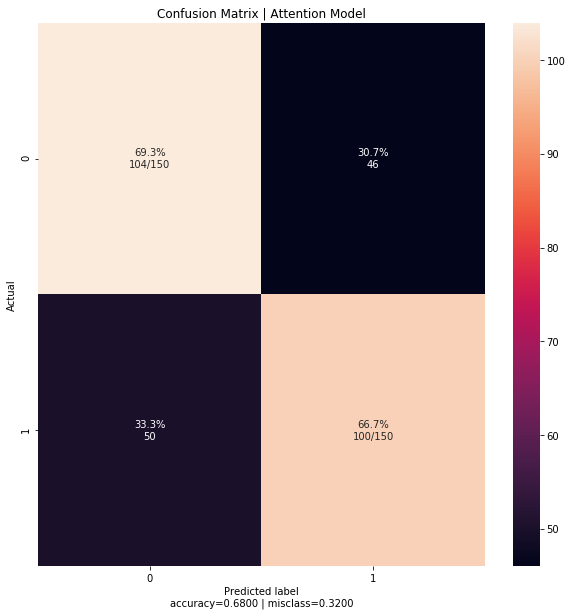

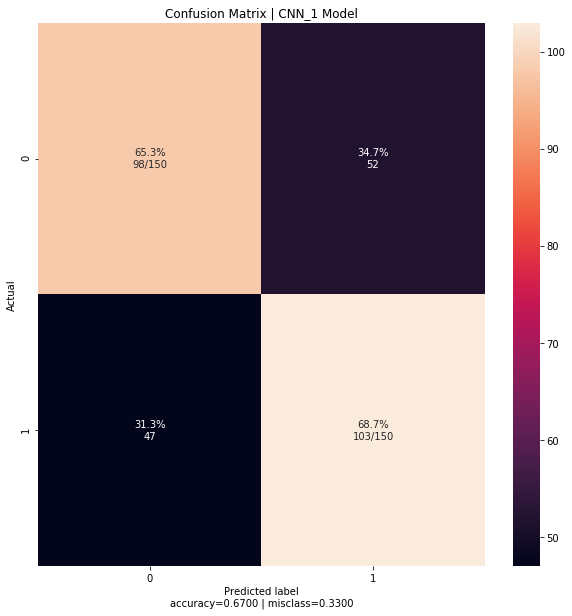

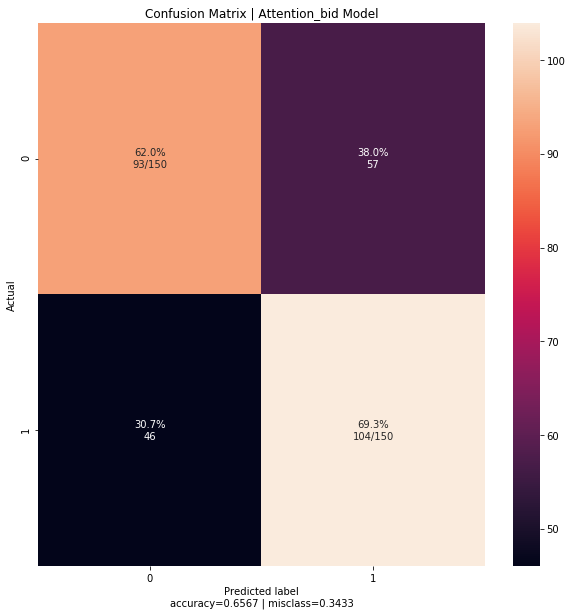

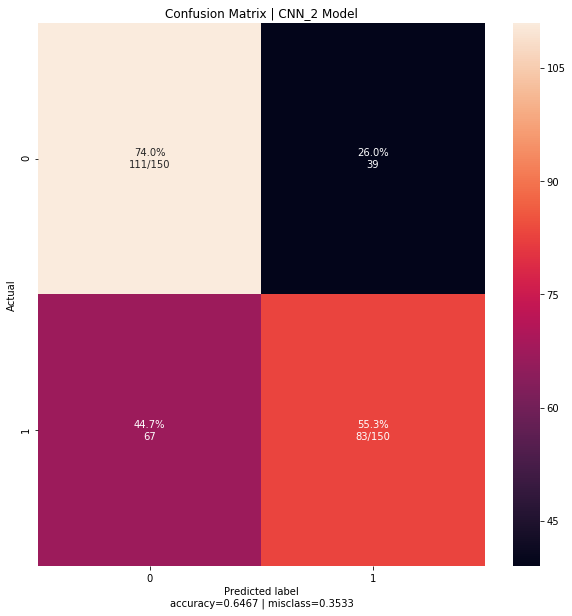

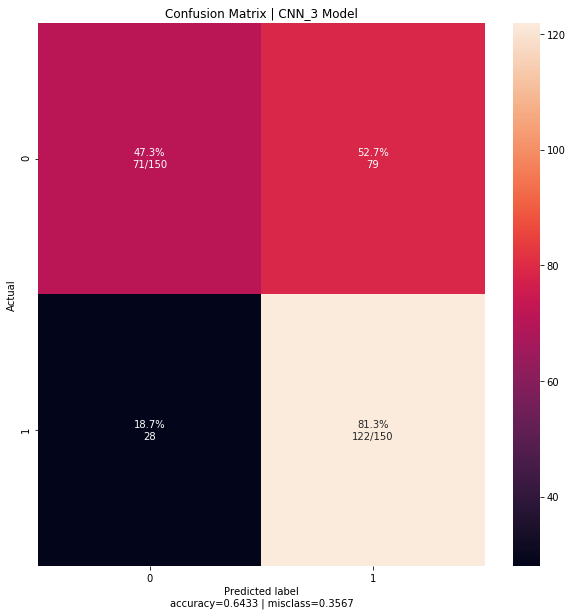

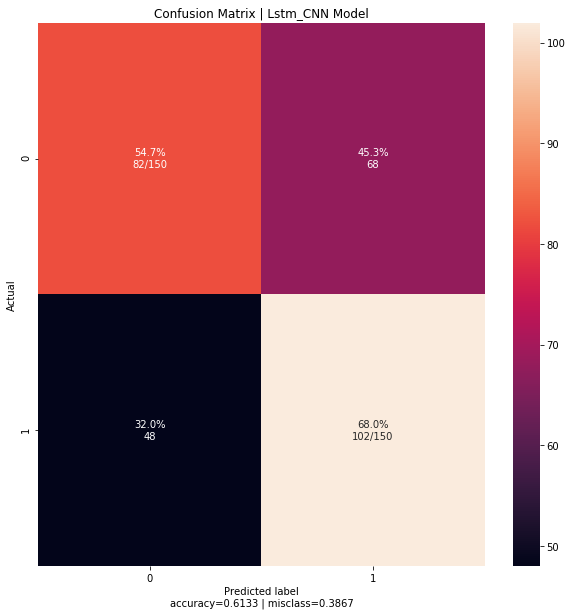

In [24]:


def cm_analysis(y_true, y_pred, labels, model_name, ymap=None, figsize=(10,10)):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    ax.set_title('Confusion Matrix | '+str(model_name))
    #plt.savefig(filename)
    accuracy = accuracy_score(y_true, y_pred) 
    misclass = 1-accuracy
    plt.xlabel('Predicted label\naccuracy={:0.4f} | misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    


model_name = ['Attention Model','CNN_1 Model','Attention_bid Model','CNN_2 Model','CNN_3 Model','Lstm_CNN Model']
for i in range(len(members)):
    yhat = members[i].predict(test_set.X)
    yhat = (yhat[:,0] >= 0.5).astype(np.int)
    
    
    
    cm_analysis(test_set.y, yhat, model_name= model_name[i], labels= [0,1], ymap=None, figsize=(10,10))

In [245]:
models_list

['Attention',
 'LSTM_CNN',
 'NiNCnn',
 'ConvPoolCnn',
 'AllCnnC',
 'Attention_bid',
 'NiNCnn_cnn4_nob_nod']

C:\Users\opeth\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\opeth\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\opeth\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\opeth\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\opeth\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

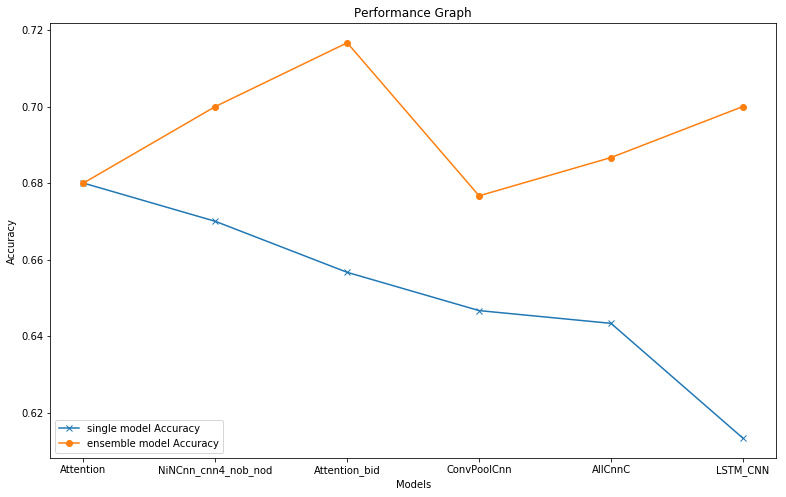

In [49]:
import matplotlib.pyplot as plt

# modlist = []
# subsub = [0,6,4,1]
# modlist = list(np.array(members)[subsub])
modlist = members

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(C=0.1)
    
    model.fit(stackedX, inputy)
    return model




# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat


def evaluate_n_members(members,n_numbers,validX,validy,testX,testy):
    # fit stacked model using the ensemble
    subset = members[:n_numbers]
    model = fit_stacked_model(subset, validX, validy)

    
    # evaluate model on test set
    yhat = stacked_prediction(subset, model, testX)
    acc = accuracy_score(testy, yhat)
    return(acc)

n_splits = len(modlist)
single_scores, ensemble_scores = list([0.68]), list([0.68])
for i in range(2, n_splits+1):
    ensemble_score = evaluate_n_members(modlist, i, valid_set.X,valid_set.y, test_set.X,test_set.y)
    _, single_score,_,_ = modlist[i-1].evaluate(test_set.X, test_set.y, verbose=0)
    #print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
# plot score vs number of ensemble members
#print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in models_list]
plt.rcParams["figure.figsize"] = (13,8)
plt.title('Performance Graph')
plt.plot(x_axis, single_scores, marker='x')
plt.plot(x_axis, ensemble_scores, marker='o')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend(['single model Accuracy', 'ensemble model Accuracy'], loc='lower left')
plt.show()


In [19]:
ensemble_scores

[0.68, 0.7, 0.7166666666666667, 0.6766666666666666, 0.6866666666666666, 0.7]

In [20]:
single_scores

[0.68, 0.67, 0.6566667, 0.64666665, 0.6433333, 0.61333334]